<center>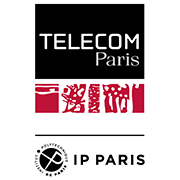</center>

<h1><center><strong><font color="chillipepper"> Lyrics Retrieval Project</font></strong></center></h1>


# Task definition

Lyrics Retrieval is the process of automatically retrieving the lyrics of a song from a text database given a query, such as the song title, artist name, or a snippet of the lyrics. It is a typical music information retrieval task, commonly applied in music recommendation systems and karaoke applications.  


In this project, we will develop a basic lyrics retrieval system given a lyrics paragraph as query, as shown by the diagram below. It will include the following steps:  

- Pre-process the lyrics
- Extract representations (query $x$ and lyrics database $y_i$)
- Rule-based quick search to find potential candidates
- Compute metrics which measures the matching between the query and the candidates $d(x,y_i)$
- Obtain a ranked list of lyrics, where a higher rank for the ground truth indicates a better-performing system

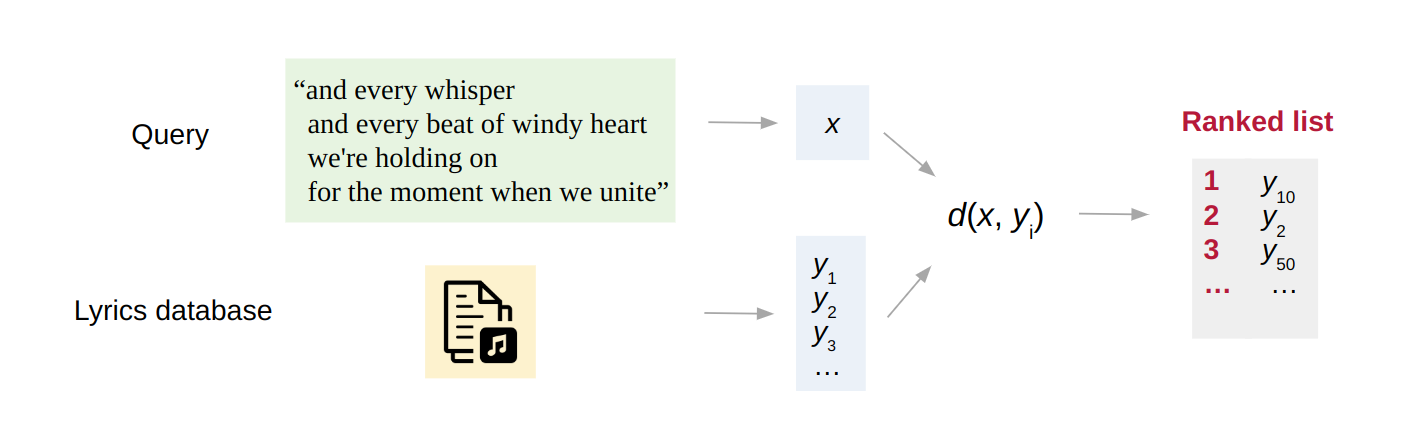

We will then further explore the following aspects:  

- How do different representations influence retrieval accuracy?
- Which paragraph are more important for retrieval, and why?
- What are the non-ground truth lyrics, and why do they appear in the top-k ranking?
- Can we do lyrics retrieval with a lyric line directly?

# Preprocessing

In [ ]:
# import packages
from langdetect import detect
import ijson
import os
import csv
from langdetect import detect, DetectorFactory
from glob import glob
import html
from tqdm import tqdm
import re
import json
import ast
import random
import pickle
import pandas as pd
import numpy as np
from collections import Counter

## Dataset

We use two datasets:
- JamendoLyrics dataset: https://github.com/f90/jamendolyrics: 20 English songs.
- Wasabi dataset: https://zenodo.org/records/5603369: lyrics with more than 2 million songs.

We will retrieve the 20 English songs in the Wasabi dataset and provide the detailed meta information, including: title, artist, and full lyrics. Each time, we are allowed to use only one paragraph at a time.

- Download both datasets
- For JamendoLyrics dataset, we are only allowed to use the lyric paragraph text in https://github.com/f90/jamendolyrics/tree/master/lyrics at the retrieving stage.
- For Wasabi dataset, all information we need is in `json/song.json`.

In [ ]:
# Download JamendoLyrics dataset
!wget https://github.com/f90/jamendolyrics/archive/refs/heads/master.zip

In [ ]:
# Download Wasabi dataset
!wget https://zenodo.org/records/5603369/files/wasabi-2-0.tar

In [ ]:
# Unzip Jamendo
!unzip master.zip -d JamendoLyrics
!rm master.zip

In [ ]:
# Unzip Wasabi
!mkdir Wasabi
!tar -xvf wasabi-2-0.tar -C Wasabi
!rm -r Wasabi/rdf/
!unzip Wasabi/json/json.zip -d Wasabi
!rm -r Wasabi/json/
!rm wasabi-2-0.tar

## Text normalization

The data is JamendoLyrics dataset is clean and no need for preprocessing. But we need to identify the English songs using the langage detection tool: `langdetect`.


We need both language identification and text normalization for Wasabi dataset. It may include: nummbers to words, symbols to words, remove unnecessary symbols, remove non-lyrics, etc. After that, you will know how many lyrics are usable for our retrieval task.

***Detection of the 10 English songs from the Jamendo database***

This code defines a function filter_english_lyrics_and_save_to_csv that scans a given directory to find English songs from the Jamendo database. It detects the language of the lyrics and filters those that are in English. For each English file, it extracts the title and artist, counts the number of paragraphs, and then saves this information in a CSV file.

In [ ]:
def filter_english_lyrics_and_save_to_csv(directory, output_csv):
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    files.sort()

    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['Title', 'Artist', 'Lyrics', 'Paragraph Count']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for file in files:
            # Filter files that end with ".txt" but not ".words.txt"
            if file.endswith('.txt') and not file.endswith('.words.txt'):
                file_path = os.path.join(directory, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        lang = detect(content)
                        # Detect the language of the content
                        if lang == 'en':
                            # Extract the title and artist
                            title, artist = file.replace('.txt', '').split('_-_')
                            # Count the number of paragraphs
                            paragraphs = content.strip().split("\n\n")
                            paragraph_count = len([p for p in paragraphs if p.strip() != ""])

                             # Write the information to the CSV
                            writer.writerow({
                                'Title': title,
                                'Artist': artist,
                                'Lyrics': content,
                                'Paragraph Count': paragraph_count
                            })
                            print(f"English detected in: {file} - {paragraph_count} paragraphs")
                except Exception as e:
                    print(f"Could not process {file}: {e}")

    print("\nLyrics from files detected as English have been saved to:", output_csv)

lyrics_directory = '/Users/ghalia/Desktop/Telecom IA/NLP/Projet Lyrics/JamendoLyrics/jamendolyrics-master/lyrics'
output_csv_path = 'english_lyrics_Jamendo_2.csv'

filter_english_lyrics_and_save_to_csv(lyrics_directory, output_csv_path)


***Cleaning the Wasabi database***

This code processes a large JSON file containing song lyrics from the Wasabi database. It performs the following tasks:

- Defines regular expressions to remove HTML tags, except < br >, and punctuation from the lyrics.
- Implements a function cleaning_with_regex to clean the text using these regular expressions.
- Converts the lyrics to lowercase

For each song, it cleans the lyrics, extracts relevant fields (lyrics, name, title), and writes the cleaned data to the output file in JSON format.
The code ensures that the output JSON file is properly formatted and includes a progress bar to track the cleaning process.

In [ ]:
# Cleaning of the lyrics from the Wasabi database

# Regular expressions for text cleaning
REMOVE_TAGS = re.compile(r"<(?!br\s*/?)[^>]+>")# Keep <br>, remove other HTML tags
REMOVE_PUNCT = re.compile(r"[.;:!?,\"()\[\]]")  # Remove punctuation

# Function for cleaning text with regex
def cleaning_with_regex(text):
    try:
        text = text.lower()                      # Convert to lowercase
        text = html.unescape(text)               # Decode HTML entities
        text = text.replace('<br>', '\n')        # Replace <br> with newlines
        text = REMOVE_TAGS.sub("", text)         # Remove other HTML tags
        text = REMOVE_PUNCT.sub("", text)        # Remove punctuation
    except Exception as e:
        print(f"Error during cleaning: {e}")
    return text

# Function to count total items in the JSON file
def count_items_in_json(file_path):
    with open(file_path, 'rb') as f:
        count = sum(1 for _ in ijson.items(f, 'item'))
    return count

input_file_path = '/Users/ghalia/Desktop/Telecom IA/NLP/Projet Lyrics/Wasabi/song.json'

# Total number of items (songs) to process for tqdm
total_items = 2079510


# Open the file in streaming mode and clean the lyrics
with open(input_file_path, 'rb') as f:
    with open('clean_paroles_filtered.json', 'w') as output_file:
        output_file.write("[\n")   # Start the JSON list

        first = True   # To manage commas between objects
        # Initialize progress bar with tqdm
        with tqdm(total=total_items, desc="Cleaning songs") as pbar:
            for song in ijson.items(f, 'item'):
                 # Clean and filter the necessary fields
                lyrics_cleaned = cleaning_with_regex(song.get('lyrics', ''))
                cleaned_song = {
                    'lyrics': lyrics_cleaned,
                    'name': song.get('name', ''),
                    'title': song.get('title', '')
                }

                if not first:
                    output_file.write(",\n")   # Add a comma to separate objects
                first = False
                json.dump(cleaned_song, output_file, ensure_ascii=False)

                # Update the progress bar
                pbar.update(1)

        output_file.write("\n]") # Close the JSON list

In [ ]:
# Method to extract a sample from the Wasabi dataset for testing purposes


# Total number of items in the JSON file for tqdm 
total_items = 2079510

# Randomly select 100 indices from the available items
random_indices = sorted(random.sample(range(total_items), 100))

# Path to the large cleaned JSON file
input_file = '/content/clean_paroles_filtered.json'

# Open the file and read the items corresponding to the selected indices with a progress bar
sample_items = []
with open(input_file, 'rb') as f:
    items = ijson.items(f, 'item')

    current_index = 0   # Current index to track the parsed items
    with tqdm(total=total_items, desc="Progression", unit="items") as pbar:
        for item in items:
            if current_index == random_indices[0]:
                # Add the item if its index matches one of the selected indices
                sample_items.append(item)
                random_indices.pop(0)   # Remove this index from the list
                if len(random_indices) == 0:
                    break # Stop if all 100 items have been retrieved
            current_index += 1
            pbar.update(1)  # Update the progress bar

output_file = 'sample_cleaned_paroles.json'
with open(output_file, 'w') as f:
    json.dump(sample_items, f, ensure_ascii=False, indent=4)

print(f"A random sample of 100 items has been saved to {output_file}")

***Detection of English songs from the cleaned Wasabi database***

In [ ]:
# Set the seed for reproducible results
DetectorFactory.seed = 0

# Function to detect if the language is English
def is_english(text):
    try:
        lang = detect(text)
        return lang == 'en'
    except:
        return False

# Stream songs and filter only the English ones
def filter_english_songs(input_file, output_file, total_songs):
    with open(input_file, 'rb') as infile, open(output_file, 'w') as outfile:
        outfile.write("[\n")
        first_item = True


        # Use tqdm to display a progress bar with estimated time remaining
        with tqdm(total=total_songs, desc="Filtrage des chansons en anglais", unit="chansons", leave=True) as pbar:
            items = ijson.items(infile, 'item')
            for item in items:
                lyrics = item.get('lyrics', '')
                if is_english(lyrics): # Check if the song is in English
                    # Write the JSON object to the output file
                    if not first_item:
                        outfile.write(",\n") # Add a comma between objects
                    json.dump({
                        'lyrics': item.get('lyrics', ''),
                        'name': item.get('name', ''),
                        'title': item.get('title', '')
                    }, outfile, ensure_ascii=False)
                    first_item = False

                 # Update the progress bar
                pbar.update(1)

        outfile.write("\n]")  # Close the JSON list

# Path to the large JSON file
input_file = '/Users/ghalia/Desktop/Telecom IA/NLP/Projet Lyrics/clean_paroles_filtered.json'
output_file = '/Users/ghalia/Desktop/Telecom IA/NLP/Projet Lyrics/english_songs.json'

# Total number of songs
total_songs = 2079510

filter_english_songs(input_file, output_file, total_songs)

print(f"The final file with only English songs has been saved to {output_file}")


In [ ]:
# Count of English lyrics 

# Open the file in read mode
with open('/Users/ghalia/Desktop/Telecom IA/NLP/Projet Lyrics/english_songs.json', 'r', encoding='utf-8') as f:
    # Use ijson to parse the file in streaming mode
    parser = ijson.items(f, 'item')

    nombre_items = 0
    nombre_lyrics = 0

   # Iterate through each item in the JSON file
    for item in parser:
        nombre_items += 1
        if 'lyrics' in item:
            nombre_lyrics += 1

print(f"Total number of items: {nombre_items}")
print(f"Number of items with 'lyrics': {nombre_lyrics}")

In [ ]:
# Count of items with empty lyrics for testing purposes

# Open the file in read mode
with open('/Users/ghalia/Desktop/Telecom IA/NLP/Projet Lyrics/english_songs.json', 'r', encoding='utf-8') as f:
    parser = ijson.items(f, 'item')

    nombre_items_vides = 0

    # Iterate through each item in the JSON file
    for item in parser:
        # Check if the item is empty or if certain fields are empty
        if not item or 'lyrics' not in item or not item['lyrics'].strip():
            nombre_items_vides += 1

print(f"Number of empty items or items without 'lyrics': {nombre_items_vides}")

In [ ]:
# Convert the Wasabi JSON to CSV

json_file = '/Users/ghalia/Desktop/Telecom IA/NLP/Projet Lyrics/english_songs_with_paragraphs_count.json'
csv_file = '/Users/ghalia/Desktop/Telecom IA/NLP/Projet Lyrics/english_songs.csv'

with open(json_file, 'r', encoding='utf-8') as f_json, open(csv_file, 'w', newline='', encoding='utf-8') as f_csv:
    # Initialize a CSV writer
    writer = csv.writer(f_csv)

     # Write the header
    writer.writerow(['lyrics', 'title', 'name', 'paragraph_count'])

    # Use ijson to read the JSON file in batches
    for item in ijson.items(f_json, 'item'):
        lyrics = item.get('lyrics', '')
        title = item.get('title', '')
        name = item.get('name', '')
        paragraph_count = item.get('paragraph_count', '')

        writer.writerow([lyrics, title, name, paragraph_count])

In [4]:
df_songs = pd.read_csv('/Users/ghalia/Desktop/lyrics_project/data_for_quick_search.csv')

In [5]:
df_songs.head()

,lyrics,title,name,paragraph_count,nb_words_per_line_per_paragraph
0,turn it up\ni don't know where you're plugging...,Turn It Up,A,1,"{""0"": {""0"": 3, ""1"": 7, ""2"": 2, ""3"": 6, ""4"": 3,..."
1,sick of you how old do you think you are\nneve...,Foghorn,A,10,"{""0"": {""0"": 10, ""1"": 7, ""2"": 10, ""3"": 13}, ""1""..."
2,my name is jason\ni'll rock yer face in\ncos i...,Cheeky Monkey,A,8,"{""0"": {""0"": 4, ""1"": 5, ""2"": 7, ""3"": 4, ""4"": 3,..."
3,got to get out more\nget in the place\ngot to ...,No. 1,A,5,"{""0"": {""0"": 5, ""1"": 4, ""2"": 5, ""3"": 5, ""4"": 11..."
4,bad idea x4 \n\nninety-nine per cent is great\...,Bad Idea,A,7,"{""0"": {""0"": 3}, ""1"": {""0"": 5, ""1"": 6, ""2"": 7},..."


# Lyrics Retrieval

## Quick search

To avoid comparing the query with all lyrics in the Wasabi dataset, we can quickly identify potential candidates by heurists, e.g. number of words in a line. You can also propose other ways to find postential candidates quickly.

***Quick Search without hashmap***

This code defines several functions to analyze the structure of song lyrics:
- count_nb_paragraphs(text): Counts the number of paragraphs in the text.
- count_nb_word_per_text(text): Counts the total number of words in the text.
- count_nb_word_per_paragraph_song(text): Counts the number of words in each paragraph of the text.
- count_word_per_line_per_paragraph(text): Counts the number of words in each line of the text.
- count_word_per_line_per_paragraph_per_song(text): Counts the number of words in each line for each paragraph of the text.

In [2]:
def count_nb_paragraphs(text):
    return text.count("\n\n") + 1


def count_nb_word_per_text(text):
    return len(text.split())


def count_nb_word_per_paragraph_song(text):
    nb_words = {}
    for i,paragraph in enumerate(text.split('\n\n')):
        nb_words[i] = count_nb_word_per_text(paragraph)
    return nb_words


def count_word_per_line_per_paragraph(text):
    nb_words = {}
    for i,line in enumerate(text.split('\n')):
        nb_words[i] = count_nb_word_per_text(line)
    return nb_words


def count_word_per_line_per_paragraph_per_song(text):
    nb_words = {}
    for i,paragraph in enumerate(text.split('\n\n')):
        nb_words[i] = count_word_per_line_per_paragraph(paragraph)
    return nb_words

In [6]:
# Quick Search without hashmap

#Searches for songs in the DataFrame that have paragraphs 
# with the same number of words per line as the given query paragraph.

def quick_search(query, df):
    
    # Number of words per line in the query paragraph
    query_words_per_line = count_word_per_line_per_paragraph(query)

    matching_songs = []

    # Use apply for vectorized optimization
    def match_paragraph(row):
        try:
            # Convert the string to a dictionary
            nb_words_per_line_dict = ast.literal_eval(row['nb_words_per_line_per_paragraph'])

            # Iterate through the paragraphs in 'nb_words_per_line_per_paragraph'
            for i, words_per_line in nb_words_per_line_dict.items():
                if words_per_line == query_words_per_line:
                    # Add to the list of matches
                    matching_songs.append((i, row['title'], row['name']))

        except (ValueError, SyntaxError) as e:
            print(f"Skipping row due to parsing error: {e}")

    # Apply the function to each row of the DataFrame
    df.apply(match_paragraph, axis=1)

    return matching_songs


***Quick Search with Hashmap***

This code defines two functions to process song lyrics in a DataFrame using the tqdm library for progress tracking.

- structure_paragraphe(texte): This function takes a text, splits it into paragraphs, and then splits each paragraph into lines. It counts the number of words in each line and returns a string representing the structure of the paragraphs.

- creer_hashmap(df): This function creates a hashmap that associates the structure of each paragraph with the corresponding song details. It iterates through each song in the DataFrame, computes the paragraph structure using structure_paragraphe, and stores the details in the hashmap, as a string. The progress of this operation is displayed using a progress bar from tqdm.

In [7]:
# Hashmap generation

def structure_paragraphe(texte):
    paragraphes = texte.split("\n\n")
    resultats = []
    for paragraphe in paragraphes:
        lignes = paragraphe.split("\n")
        compte_par_ligne = [str(len(ligne.split())) for ligne in lignes]
        resultats.append(f"[{' '.join(compte_par_ligne)}]")
    return ' '.join(resultats)

# Function to create a hashmap associating the structure of each paragraph to the songs
def creer_hashmap(df):
    hashmap = {}
    # Iterate through each song in the DataFrame with a progress bar
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Création de la hashmap"):
        # Get the paragraphs of the song
        paragraphes = row['lyrics'].split("\n\n")

        # Compute the structure for each paragraph
        for paragraphe in paragraphes:
            structure = structure_paragraphe(paragraphe)  # Get the paragraph structure

             # If the structure already exists in the hashmap, append the paragraph and song details to the list
            if structure in hashmap:
                hashmap[structure].append({
                    'title': row['title'],
                    'name': row['name'],
                    'paragraphe': paragraphe,
                    'word_count_vect' : structure
                })
            else:
                # Otherwise, create a new entry in the hashmap
                hashmap[structure] = [{
                    'title': row['title'],
                    'name': row['name'],
                    'paragraphe': paragraphe,
                    'word_count_vect' : structure
                }]

    return hashmap



In [8]:
# Test of the function structure_paragraphe
structure_paragraphe("finally figured it out i got my head around it\nalthough i know i've got to get myself out of this habit\nof falling for someone who's out of reach it's unrealistic\nmr dream won't become a reality but was it meant to be")

'[10 12 10 12]'

In [9]:
# QuickSearch function using the hashmap for an input as a single paragraph

def quicksearch_hashmap(hashmap, text):

    structure_recherchee = structure_paragraphe(text)

    # Check if the structure exists in the hashmap
    if structure_recherchee in hashmap:
        return pd.DataFrame(hashmap[structure_recherchee])
    else:
        return pd.DataFrame([], columns=['title', 'name', 'paragraphe', 'structure'])

Below, the quicksearch_hashmap_generalise function searches for specific paragraph structures within song lyrics. It takes a hashmap and input data (either a DataFrame or a string). For each paragraph in the input, it identifies the paragraph structure using the structure_paragraphe function. If the structure matches an entry in the hashmap, it appends relevant information to a result DataFrame. If the input is invalid, it raises a ValueError.

In [10]:
def quicksearch_hashmap_generalise(hashmap, input_data):
    result = pd.DataFrame()

    # Vérification si l'entrée est un DataFrame
    if isinstance(input_data, pd.DataFrame):
        print("Input is a DataFrame.")
        # Itération sur chaque chanson dans la colonne 'Lyrics'
        for song_index, song in input_data['Lyrics'].items():
            paragraphs_song = song.split("\n\n")
            print(f"Processing {len(paragraphs_song)} paragraphs for song at index {song_index}.")

            # Itération sur chaque paragraphe de la chanson
            for paragraph_index, paragraph in enumerate(paragraphs_song):
                structure_recherchee = structure_paragraphe(paragraph)
                if structure_recherchee in hashmap:
                    print(f"Match found for structure: {structure_recherchee} in song at index {song_index}.")
                    temp_df = pd.DataFrame(hashmap[structure_recherchee])
                    if temp_df.empty:
                        print(f"Temporary DataFrame is empty for structure: {structure_recherchee}.")
                    else:
                        temp_df['Chanson_Jamendo'] = input_data.loc[song_index, 'Title']
                        temp_df['Paragraphe_Jamendo'] = paragraph
                        result = pd.concat([result, temp_df], ignore_index=True)
                        if result.empty:
                            print("Failed to concatenate DataFrame.")
                else:
                    print(f"No match found for structure: {structure_recherchee} in song at index {song_index}.")

        return result

    # Si l'entrée est une chaîne avec un ou plusieurs paragraphes
    elif isinstance(input_data, str):
        print("Input is a string.")
        paragraphs_from_string_input = input_data.split("\n\n")
        print(f"Processing {len(paragraphs_from_string_input)} paragraphs from input string.")

        for paragraph_index, p in enumerate(paragraphs_from_string_input):
            structure_recherchee = structure_paragraphe(p)
            if structure_recherchee in hashmap:
                print(f"Match found for structure: {structure_recherchee} in string input.")
                temp_df = pd.DataFrame(hashmap[structure_recherchee])
                if temp_df.empty:
                    print(f"Temporary DataFrame is empty for structure: {structure_recherchee}.")
                else:
                    temp_df['Chanson_Jamendo'] = 'undefined'
                    temp_df['Paragraphe_Jamendo'] = p
                    result = pd.concat([result, temp_df], ignore_index=True)
                    if result.empty:
                        print("Failed to concatenate DataFrame.")
            else:
                print(f"No match found for structure: {structure_recherchee} in string input.")
        return result
    else:
        raise ValueError("Invalid input. Please provide a DataFrame or a string representing a paragraph.")

In [ ]:
# Create the hashmap once from the DataFrame with a progress bar
hashmap = creer_hashmap(df_songs)

In [ ]:
# Save the hashmap to a pickle file for later use
def enregistrer_hashmap(hashmap, filename):
    with open(filename, 'wb') as file:   # 'wb' for writing in binary mode
        pickle.dump(hashmap, file)
    print(f"Hashmap enregistrée dans le fichier {filename}")

In [ ]:
enregistrer_hashmap(hashmap, "hashmap_lyrics.pkl")

In [11]:
# Load the hashmap from a pickle file
def charger_hashmap(filename):
    with open(filename, 'rb') as file:  # 'rb' for reading in binary mode
        hashmap = pickle.load(file)
    print(f"Hashmap chargée depuis le fichier {filename}")
    return hashmap

In [12]:
hashmap_chargee = charger_hashmap("hashmap_lyrics.pkl")

Hashmap chargée depuis le fichier hashmap_lyrics.pkl


In [13]:
query_paragraph = """people gonna hate let them do it
shine like it ain't nothing to it
damn you a major influence
skate like there ain't nothing doing
live life don't say nothing to them

i've been thinking about you lately lately
that's a massive understatement baby
cause i think about you all day and all night
but is it right

finally figured it out i got my head around it
although i know i've got to get myself out of this habit
of falling for someone who's out of reach it's unrealistic
mr dream won't become a reality but was it meant to be"""

In [14]:
# Test of the quicksearch_hashmap_generalise function
quicksearch_hashmap_generalise(hashmap_chargee, query_paragraph).head()


Input is a string.
Processing 3 paragraphs from input string.
Match found for structure: [7 7 5 6 7] in string input.
Match found for structure: [7 5 10 4] in string input.
Match found for structure: [10 12 10 12] in string input.


,title,name,paragraphe,word_count_vect,Chanson_Jamendo,Paragraphe_Jamendo
0,Magic Flame,Almah,a decision can change all your ways\nyour beli...,[7 7 5 6 7],undefined,people gonna hate let them do it\nshine like i...
1,I Think I'm Gonna Like It Here,Ann Reinking,no need to pick up any toys\nno finger will yo...,[7 7 5 6 7],undefined,people gonna hate let them do it\nshine like i...
2,Mr. Superlove,Ass Ponys,the storm was blowing from the south\nthe bloo...,[7 7 5 6 7],undefined,people gonna hate let them do it\nshine like i...
3,Yo Te Amo(I Still Love You),Aventura,baby im sorry te juro im sorry \nmira me a los...,[7 7 5 6 7],undefined,people gonna hate let them do it\nshine like i...
4,Yo Te Amo(I Still Love You),Aventura,baby im sorry te juro im sorry\nmira me a los ...,[7 7 5 6 7],undefined,people gonna hate let them do it\nshine like i...


In [18]:
jamendo_songs = pd.read_csv("/Users/ghalia/Desktop/lyrics_project/english_lyrics_Jamendo_2.csv")

In [19]:
jamendo_songs.head()

,Title,Artist,Lyrics,Paragraph Count
0,Avercage,Embers,through days of thunders\ncontinuing stolid sm...,10
1,Color_Out,Falling_Star,someday you'll come back here\nand you'll open...,6
2,Cortez,Feel__Stripped_,yeah oh\n\nplease don't stand over here\nact l...,9
3,Explosive_Ear_Candy,Like_The_Sun,i see your face everywhere that i go\non the c...,9
4,HILA,Give_Me_the_Same,lay awake at night\nwondering how could i\nlet...,1


In [20]:
# Result of the quicksearch function with the hashmap for each paragraph of the Jamendo songs
result_quicksearch = quicksearch_hashmap_generalise(hashmap_chargee, jamendo_songs)

Input is a DataFrame.
Processing 10 paragraphs for song at index 0.
Match found for structure: [4 5 3 7] in song at index 0.
Match found for structure: [3 6 3 6] in song at index 0.
Match found for structure: [2 8 2 6 2] in song at index 0.
Match found for structure: [4 6 4 6] in song at index 0.
Match found for structure: [4 7 4 7] in song at index 0.
Match found for structure: [2 8 2 6 2] in song at index 0.
Match found for structure: [4 6 4 6] in song at index 0.
Match found for structure: [7] in song at index 0.
Match found for structure: [4 6 4 6] in song at index 0.
Match found for structure: [4 3 3 4 4 3 2] in song at index 0.
Processing 6 paragraphs for song at index 1.
No match found for structure: [5 6 11 5 5 7 5 4 4] in song at index 1.
Match found for structure: [6 6 7 7 6 4] in song at index 1.
Match found for structure: [8 5 5 9 5 5] in song at index 1.
No match found for structure: [6 6 4 10 11 5 5] in song at index 1.
Match found for structure: [4 6] in song at index 1.

In [21]:
result_quicksearch.head()

,title,name,paragraphe,word_count_vect,Chanson_Jamendo,Paragraphe_Jamendo
0,Another 100 Years,A New Beginning,say you love me\ntell me that you care\nand th...,[4 5 3 7],Avercage,through days of thunders\ncontinuing stolid sm...
1,Wild Fire Metal Bitch,Abigail,bitch be my slave\nthat's your reason to live\...,[4 5 3 7],Avercage,through days of thunders\ncontinuing stolid sm...
2,Smash And Grab,Absent Kid,cheap seats and magazines\ncomic-book hero wor...,[4 5 3 7],Avercage,through days of thunders\ncontinuing stolid sm...
3,Smash And Grab,Absent Kid,cheap seats and magazines\ncomic-book hero wor...,[4 5 3 7],Avercage,through days of thunders\ncontinuing stolid sm...
4,Life Is A Flower,Ace Of Base,life is a flower\nso precious in your hand\nca...,[4 5 3 7],Avercage,through days of thunders\ncontinuing stolid sm...


## Representation extraction

### Bag-of-Words

In [24]:
def count_words(df, column_text_name, voc=None):
    """
    Vectorize text: return count of each word in the text snippets with a progress bar.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the text data.
    column_text_name : str
        The column name where the text is located.
    voc : dict, optional
        A pre-defined vocabulary. If None, the vocabulary will be built from the data.

    Returns
    -------
    vocabulary : dict
        A dictionary mapping each word to its index.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    texts = df[column_text_name].to_list()
    n_samples = len(texts)

    # Build the vocabulary if not provided
    if voc is None:
        all_words = [word for text in texts for word in text.split()]
        unique_words = set(all_words)
        n_features = len(unique_words)
        vocabulary = {word: idx for idx, word in enumerate(unique_words)}
    else:
        vocabulary = voc
        n_features = len(vocabulary)

    # Create a count matrix (n_samples x n_features) initialized with zeros
    counts = np.zeros((n_samples, n_features), dtype=int)

    # Use tqdm to display a progress bar with ETA
    with tqdm(total=n_samples, desc="Counting words", unit="text") as pbar:
        for i, text in enumerate(texts):
            word_counts = Counter(text.split())  # Count words in the current text
            for word, count in word_counts.items():
                if word in vocabulary:  # Only count words that are in the vocabulary
                    counts[i, vocabulary[word]] = count
            pbar.update(1)  # Update the progress bar for each text processed

    return vocabulary, counts



In [25]:
# Bag of words with library sk learn

from sklearn.feature_extraction.text import CountVectorizer

def bag_of_words_sklearn(df, column_text_name):
    """
    Vectorize text using CountVectorizer from scikit-learn.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the text data.
    column_text_name : str
        The column name where the text is located.

    Returns
    -------
    counts : sparse matrix, shape (n_samples, n_features)
        The counts of each word in each text.
    vocabulary : dict
        A dictionary mapping each word to its index.
    """
    vectorizer = CountVectorizer()  # Initialize the CountVectorizer
    counts = vectorizer.fit_transform(df[column_text_name])  # Transform the text data into a BoW
    vocabulary = vectorizer.vocabulary_  # Get the vocabulary (word to index mapping)

    return vocabulary, counts

In [ ]:
# Save vocabulary as json

def save_vocabulary_to_json(vocabulary, file_path):
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(vocabulary, f, ensure_ascii=False, indent=4)

file_path = 'vocabulary.json'
save_vocabulary_to_json(voc, file_path)


### Word2Vec

In [27]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk

In [ ]:
# Tokenization of each lyric

tqdm.pandas()

# Apply tokenization with lowercase conversion to a specified column in a DataFrame.
# Displays a progress bar for tracking.

df['tokens'] = df['lyrics'].progress_apply(lambda x: word_tokenize(x))


The code below trains a Word2Vec model using the gensim library on the Wasabi dataset. 

In [28]:
import gensim
from gensim.models import Word2Vec
from tqdm import tqdm
import multiprocessing

In [ ]:
# Training a Word2Vec model on Wasabi lyrics

class TqdmCallback(gensim.models.callbacks.CallbackAny2Vec):
    '''Callback to print loss after each epoch and update tqdm progress bar'''
    def __init__(self, total_epochs):
        self.epoch = 0
        self.total_epochs = total_epochs
        self.pbar = tqdm(total=total_epochs, desc="Entraînement Word2Vec", unit="epoch")

    def on_epoch_end(self, model):
        self.epoch += 1
        self.pbar.update(1)   # Update the progress bar after each epoch
        print(f"Epoch {self.epoch}/{self.total_epochs} terminée.")

    def on_train_end(self, model):
        self.pbar.close()  # Close the progress bar when training ends

# Preparing the data (Ensure that `sentences` is a list of lists of tokens)
sentences = []

# Add tokens line by line with a progress bar
for tokens in tqdm(df['tokens'], desc="Converting tokens into list"):
    sentences.append(tokens)
# Define parameters for Word2Vec model training
total_epochs = 10  # For example, train for 10 epochs

model = Word2Vec(
    vector_size=100,         # Size of word vectors
    window=5,                # Context window size
    min_count=1,             # Minimum word frequency (adjust as needed)
    workers=multiprocessing.cpu_count(),  # Use all available CPU cores
    sg=1,                    # Use Skip-gram algorithm
    compute_loss=True        # Track training loss
)

# Build vocabulary directly from the sentences
model.build_vocab(sentences)

# Train the model and display progress
model.train(
    sentences,
    total_examples=model.corpus_count,
    epochs=total_epochs,
    callbacks=[TqdmCallback(total_epochs)]
)

# Save the model for future use
model.save("word2vec_lyrics_full.model")


In [ ]:

# Load the trained Word2Vec model

model = Word2Vec.load("/Users/ghalia/Desktop/nlp_project/modele_word2vec/word2vec_lyrics_full.model")

In [ ]:

# Test similarity with the trained model on Wasabi
similar_words = model.wv.most_similar_cosmul('god', topn=10)  # Returns the top 10 most similar words
print(similar_words)

***With Word2Vec Google News 300***

This code uses the Gensim library to load a pre-trained Word2Vec model called “word2vec-google-news-300.” The model is trained on a large dataset from Google News and has 300-dimensional word embeddings. 

In [44]:
import gensim.downloader as api

# Load the pre-trained Word2Vec model from the Gensim library
model_google = api.load("word2vec-google-news-300")

In [20]:
# Example: finding the top 10 most similar words to 'me'
similar_words = model_google.most_similar('god', topn=10)
print(similar_words)

[('gods', 0.7856108546257019), ('deity', 0.7325143218040466), ('God', 0.666293203830719), ('diety', 0.6607768535614014), ('goddess', 0.6518734693527222), ('deities', 0.6512717604637146), ('lord', 0.6350281238555908), ('god_Zeus', 0.6218456625938416), ('Almighty', 0.6040672063827515), ('Gods', 0.6037754416465759)]


## Compute match

We compute the distance between the query and the candidates $d(x,y_i)$; then use this distance to rank the candidates, and return the top 10 candidates for evaluation.

Different distance measures are needed depending on the representations used.

### Cosine similarity

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

In [30]:
# Calculates the mean vector for a list of words using a Word2Vec model. 

def get_mean_vector(model, words):
    words = [word for word in words if word in model.wv.key_to_index]
    if len(words) >= 1:
        return np.mean([model.wv[word] for word in words], axis=0)
    else:
        return np.zeros(model.vector_size)

In [31]:
# Another function but this time using the word2vec model of google news 300

def get_mean_vector_Google(model, words):
    # Filter words to include only those in the model's vocabulary
    words = [word for word in words if word in model.key_to_index]
    if len(words) > 0:
        return np.mean([model[word] for word in words], axis=0)
    else:
        # Return a zero vector if no words are in the model's vocabulary
        return np.zeros(model.vector_size)

In [32]:
# Computation of the cosine Distance
from sklearn.metrics.pairwise import cosine_similarity

def similarities_cosine(paragraph1, paragraph2, model):
      # Get the average vector for paragraph 1
    vector1 = get_mean_vector_Google(model, paragraph1.split())

     # Get the average vector for paragraph 2
    vector2 = get_mean_vector_Google(model, paragraph2.split())

     # Compute cosine similarity
    similarity = cosine_similarity([vector1], [vector2])[0][0]

    return similarity

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_mean_vector(model, words):
    # Get the mean vector of a list of words but ignoring words not present in the model.
    valid_vectors = [model[word] for word in words if word in model]
    if not valid_vectors:
        return np.zeros(model.vector_size)
    mean_vector = np.mean(valid_vectors, axis=0)
    # Normalize the mean vector to avoid extreme variations
    norm = np.linalg.norm(mean_vector)
    return mean_vector / norm if norm != 0 else mean_vector

def similarities_cosine_by_line(paragraph1, paragraph2, model):
    # Split paragraphs into lines (assumes preprocessed text)
    lines1 = [line for line in paragraph1.splitlines() if line.strip()]
    lines2 = [line for line in paragraph2.splitlines() if line.strip()]

    # Compute the mean vector for each line and normalize each line
    vectors1 = [get_mean_vector(model, line.split()) for line in lines1]
    vectors2 = [get_mean_vector(model, line.split()) for line in lines2]

    # Average the line vectors for each paragraph
    paragraph_vector1 = np.mean(vectors1, axis=0) if vectors1 else np.zeros(model.vector_size)
    paragraph_vector2 = np.mean(vectors2, axis=0) if vectors2 else np.zeros(model.vector_size)


    # Check if vectors are non-zero to avoid errors in cosine similarity
    if np.all(paragraph_vector1 == 0) or np.all(paragraph_vector2 == 0):
        return 0.0

    # Normalize the paragraph vectors for better stability
    paragraph_vector1 /= np.linalg.norm(paragraph_vector1) if np.linalg.norm(paragraph_vector1) != 0 else 1
    paragraph_vector2 /= np.linalg.norm(paragraph_vector2) if np.linalg.norm(paragraph_vector2) != 0 else 1

    # Calculate and return the cosine similarity
    similarity = cosine_similarity([paragraph_vector1], [paragraph_vector2])[0][0]
    return similarity


### Jaccard Similarity

In [35]:
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer


# Function to compute the Jaccard distance between two paragraphs
def distance_jaccard(paragraphe1, paragraphe2):

    #Compute the Jaccard distance (1 - similarity) between two paragraphs
    # Convert paragraphs into sets of words
    set1 = set(paragraphe1.split())
    set2 = set(paragraphe2.split())

    # Compute the intersection and union of the two sets
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))

    # Calculate the Jaccard distance (1 - similarity)
    if union == 0:
        return 1 # If the union is empty, consider maximum distance
    return 1 - (intersection / union)


# Function to compute the Jaccard distance between two paragraphs using Scikit-learn
def distance_jaccard_sickit(paragraphe1, paragraphe2):
    # Convert paragraphs into sets of words
    set1 = set(paragraphe1.split())
    set2 = set(paragraphe2.split())

    # Create a list of all unique words (vocabulary)
    vocabulaire = list(set1.union(set2))

    # Create a binary vector for each paragraph
    binarizer = MultiLabelBinarizer(classes=vocabulaire)
    vecteur1 = binarizer.fit_transform([set1])[0]
    vecteur2 = binarizer.transform([set2])[0]

    # Compute the Jaccard score
    score_jaccard = jaccard_score(vecteur1, vecteur2, average='binary')

    # Return the Jaccard similarity score

    return score_jaccard

# Compute Jaccard distances (using sickit) for paragraphs obtained from quick search
def calculer_distances_jaccard(df, paragraphe_recherche):

    # Check if the DataFrame is empty
    if df.empty:
        print("No similar paragraphs found after the quick search.")
        return pd.DataFrame()  # Return an empty DataFrame to stop processing

    # List to store results with distances
    resultats = []

    for index, row in df.iterrows():
        paragraphe_courant = row['paragraphe']
        distance = distance_jaccard_sickit(paragraphe_recherche, paragraphe_courant)
        resultats.append({
            'title': row['title'],
            'name': row['name'],
            'paragraphe': paragraphe_courant,
            'distance_jaccard': distance
        })

    # Convert to DataFrame and sort by Jaccard distance (closest first)
    resultats_df = pd.DataFrame(resultats)
    resultats_df = resultats_df.sort_values(by='distance_jaccard', ascending=False)

    top_10_resultats = resultats_df.head(1)

    return top_10_resultats


In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Jaccard with Bag of Words
def pars_to_bow(list_pars :list):
    """Creates a word occurrence/presence matrix from a list of paragraphs.

    Parameters
    ----------
    list_pars : list
        List of paragraphs.

    Returns
    -------
    bow_a : ndarray
        Word occurrence/presence matrix.
    """
    vectorizer = CountVectorizer()
    Bow = vectorizer.fit_transform(list_pars)  # Transform the list of paragraphs into a sparse matrix
    bow_a = Bow.toarray()  # Convert the sparse matrix into a dense array
    return bow_a

def pars_to_bow_tf_idf(list_pars :list):
  """Creates a word occurrence/presence matrix using TF-IDF from a list of paragraphs.

  Parameters
  ----------
  list_pars : list
      List of paragraphs.
  """
  # Initialize the TF-IDF vectorizer
  tfidf_vectorizer = TfidfVectorizer()

  # Transform the corpus
  tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)  # Generate the TF-IDF matrix from the list of paragraphs

  # Convert to a dense matrix for visualization
  tfidf_matrix_dense = tfidf_matrix.toarray()

  return np.round(tfidf_matrix_dense).astype(int)  # Round the values and convert to integers for presence representation


In [37]:
from sklearn.metrics import jaccard_score
import numpy as np
import pandas as pd

# Example query
requete = "machine learning et intelligence artificielle"

# Example paragraphs
paragraphes = [
    "L'intelligence artificielle est un domaine en pleine expansion.",
    "L'apprentissage automatique, ou machine learning, est une branche de l'IA.",
    "Les réseaux de neurones sont utilisés en apprentissage profond.",
    "Le deep learning est un sous-ensemble de l'apprentissage automatique."
]

corpus = [requete] + paragraphes
bow_a = pars_to_bow(corpus)  # You can also use pars_to_bow_tf_idf

def calculate_jaccard_distances(corpus, bow_matrix, save=False, output_file="jaccard_distances.csv"):
    """
    Calculate the Jaccard distance between a query and paragraphs, and save results if needed.

    :param corpus: List containing the query and corpus paragraphs (query + paragraphs).
    :param bow_matrix: Bag of Words matrix of the corpus numpy.ndarray.
    :param save: Boolean indicating whether to save distances to a CSV file.
    :param output_file: Name of the output CSV file if save=True.
    :return: DataFrame containing Jaccard distances sorted by ascending distance.
    """
    # Initialize distances
    distances = []

    # Calculate Jaccard distances
    for i in range(1, len(corpus)):
        distance = 1 - jaccard_score(bow_matrix[0], bow_matrix[i])  # Compute Jaccard distance
        distances.append((paragraphes[i-1], distance))  # Append paragraph and distance as a tuple

    distances = dict(distances)
    distances = dict(sorted(distances.items(), key=lambda x: x[1]))  # Sort by ascending distance
    # Create a DataFrame sorted by ascending distance
    distances_df = pd.DataFrame(distances, index=[0])

    # Display the results
    print(distances_df)

    # Save to a CSV file if required
    if save:
        distances_df.to_csv(output_file, index=False, encoding='utf-8')
        print(f"Distances saved to file: {output_file}")

    return distances_df


jaccard_distances = calculate_jaccard_distances(
    corpus,
    bow_matrix=bow_a,
    save=False,
)


   L'intelligence artificielle est un domaine en pleine expansion.  \
0                                           0.818182                 

   L'apprentissage automatique, ou machine learning, est une branche de l'IA.  \
0                                           0.846154                            

   Le deep learning est un sous-ensemble de l'apprentissage automatique.  \
0                                           0.928571                       

   Les réseaux de neurones sont utilisés en apprentissage profond.  
0                                                1.0                


***Calculation of results for all paragraphs from Jamendo***

In [38]:
# Test Jaccard Distance on a Jamendo song 

# Get paragraphs via quicksearch
paragraphe_recherche = "i wanna go out but there's no-one about\nall my friends want a quiet one at home\nthe same age as me and\nthey're husbands-to-be yeah\neverybody in the building"
p_test2 = "wide awake yeah i've crossed the line\ni'm coming home\ni'm running back to real life\nthrough the start\nwhere i could breathin' freely baby"
p_test_wasabi = "people gonna hate let them do it\nshine like it ain't nothing to it\ndamn you a major influence\nskate like there ain't nothing doing\nlive life don't say nothing to them"
# Assume df_result comes from quicksearch_hashmap()
df_result = quicksearch_hashmap(hashmap_chargee, p_test_wasabi)

# Remove duplicates
df_result_sans_doublons = df_result.drop_duplicates(subset=['title', 'paragraphe'])

# Compute Jaccard distances and get sorted results
resultats_distances = calculer_distances_jaccard(df_result_sans_doublons, p_test_wasabi)

# Get the song with the paragraph closest to the query
chanson_la_plus_proche = resultats_distances.iloc[0]  # The first result is the closest

# Display information about the closest song
print("Closest song:")
print(f"Query paragraph\n:" + p_test_wasabi)
print(f"Title: {chanson_la_plus_proche['title']}")
print(f"Artist: {chanson_la_plus_proche['name']}")
print(f"Paragraph \n : {chanson_la_plus_proche['paragraphe']}")
print(f"Jaccard Distance: {chanson_la_plus_proche['distance_jaccard']}")


Closest song:
Query paragraph
:people gonna hate let them do it
shine like it ain't nothing to it
damn you a major influence
skate like there ain't nothing doing
live life don't say nothing to them
Title: Blame It On Love
Artist: Smokey Robinson
Paragraph 
 : there ain't no use in harping on
girl it's time to let it be
we did all we could
and it won't do no good
to blame it on you and me
Jaccard Distance: 0.16666666666666666


### Levenshtein distance

In [39]:
from rapidfuzz.distance import Levenshtein
import numpy as np

# Function to calculate the normalized Levenshtein distance between two paragraphs
def distance_levenshtein_normalisee(paragraphe1, paragraphe2):
    # Calculate the raw Levenshtein distance
    distance_brute = Levenshtein.distance(paragraphe1, paragraphe2)

    # Calculate the maximum length of the two strings
    longueur_max = max(len(paragraphe1), len(paragraphe2))

    # If one of the strings is empty, the normalized distance is 1 (completely different)
    if longueur_max == 0:
        return 1.0

    # Calculate the normalized distance
    distance_normalisee = distance_brute / longueur_max

    return distance_normalisee

def similarite_levenshtein(paragraphe1, paragraphe2):
    # Calculate the normalized distance
    distance_normalisee = distance_levenshtein_normalisee(paragraphe1, paragraphe2)

    # Similarity is the inverse of the normalized distance
    similarite = 1 - distance_normalisee

    return similarite

# Compute Levenshtein distances for paragraphs obtained from quicksearch
def calculer_distances_levenshtein(df, paragraphe_recherche):
    # Check if the DataFrame is empty
    if df.empty:
        print("No similar paragraphs found after the quick search.")
        return pd.DataFrame()  # Return an empty DataFrame to stop processing

    # List to store results with distances
    resultats = []

    for index, row in df.iterrows():
        paragraphe_courant = row['paragraphe']
        distance = similarite_levenshtein(paragraphe_recherche, paragraphe_courant)
        resultats.append({
            'title': row['title'],
            'name': row['name'],
            'paragraphe': paragraphe_courant,
            'distance_levenshtein': distance
        })

    # Convert to DataFrame and sort by Levenshtein distance (closest first)
    resultats_df = pd.DataFrame(resultats)
    resultats_df = resultats_df.sort_values(by='distance_levenshtein', ascending=True)

    top_10_resultats = resultats_df.head(10)

    return top_10_resultats


In [40]:
# Levenshtein Distances:

# Get paragraphs via quicksearch
paragraphe_recherche = "dust off the gears that mole this machine\n'cuz they feel so old\nthey don't work no more\nshow me a day that brings me better things\n'cuz these days don't lie\nyou're running out of time"

# Assume df_result comes from quicksearch_hashmap()
df_result = quicksearch_hashmap(hashmap_chargee, paragraphe_recherche)

# Remove duplicates
df_result_sans_doublons = df_result.drop_duplicates(subset=['title', 'paragraphe'])

# Calculate Levenshtein distances and get sorted results
resultats_distances = calculer_distances_levenshtein(df_result_sans_doublons, paragraphe_recherche)

# Display the results
resultats_distances.head(10)

# Get the song with the paragraph closest to the query
chanson_la_plus_proche = resultats_distances.iloc[0]  # The first result is the closest
chanson_la_plus_proche2 = resultats_distances.iloc[2]  # The third result
chanson_la_plus_proche3 = resultats_distances.iloc[3]  # The fourth result

# Display information about the closest song
print("Closest song:")
print(f"Query paragraph: " + paragraphe_recherche)
print(f"Title: {chanson_la_plus_proche['title']}")
print(f"Artist: {chanson_la_plus_proche['name']}")
print(f"Paragraph: {chanson_la_plus_proche['paragraphe']}")
print(f"Levenshtein Distance: {chanson_la_plus_proche['distance_levenshtein']}")

# Display information about the second closest song
print("\nSecond closest song:")
print(f"Query paragraph: " + paragraphe_recherche)
print(f"Title: {chanson_la_plus_proche2['title']}")
print(f"Artist: {chanson_la_plus_proche2['name']}")
print(f"Paragraph: {chanson_la_plus_proche2['paragraphe']}")
print(f"Levenshtein Distance: {chanson_la_plus_proche2['distance_levenshtein']}")

# Display information about the third closest song
print("\nThird closest song:")
print(f"Query paragraph: " + paragraphe_recherche)
print(f"Title: {chanson_la_plus_proche3['title']}")
print(f"Artist: {chanson_la_plus_proche3['name']}")
print(f"Paragraph: {chanson_la_plus_proche3['paragraphe']}")
print(f"Levenshtein Distance: {chanson_la_plus_proche3['distance_levenshtein']}")


Closest song:
Query paragraph: dust off the gears that mole this machine
'cuz they feel so old
they don't work no more
show me a day that brings me better things
'cuz these days don't lie
you're running out of time
Title: Shabby Doll
Artist: Elvis Costello & The Attractions
Paragraph: and being what you might call a whore
always worked for me before
now i'm a shabby doll
untie the gag the cat's out of the bag
but won't show his claws
he's just a shabby doll
Levenshtein Distance: 0.20765027322404372

Second closest song:
Query paragraph: dust off the gears that mole this machine
'cuz they feel so old
they don't work no more
show me a day that brings me better things
'cuz these days don't lie
you're running out of time
Title: The Heart Of Worship
Artist: Matt Maher
Paragraph: i'm coming back to the heart of worship
and it's all about you 
it's all about you jesus
i'm sorry lord for the thing i've made it
and it's all about you 
it's all about you jesus
Levenshtein Distance: 0.22404371584

### Compute Match with the 3 distances


In [ ]:
def top_similarite(distance, paragraphs, hash, top=3, model=None):
    """
    Trouve les paragraphes les plus similaires en utilisant la distance spécifiée.

    Args:
        distance (str): Type de distance ("j", "l", "c").
        paragraphs (str): Paragraphe à rechercher.
        hashmap (dict): Hashmap des données pour la recherche rapide.
        top (int): Nombre de résultats similaires à retourner.
        model (object): Modèle pour la similarité cosinus (optionnel).

    Returns:
        pd.DataFrame: DataFrame structuré contenant les résultats.
    """
    # Étape 1 : Recherche rapide
    results_quickSearch = quicksearch_hashmap_generalise(hash, paragraphs)

    # Vérifier si le DataFrame est vide
    if results_quickSearch.empty:
        print("Le DataFrame `results_quickSearch` est vide. Aucun résultat trouvé.")
        return pd.DataFrame()  # Retourne un DataFrame vide

    # Vérifier que les colonnes nécessaires sont présentes
    required_columns = ['Chanson_Jamendo', 'Paragraphe_Jamendo']
    missing_columns = [col for col in required_columns if col not in results_quickSearch.columns]

    if missing_columns:
        print(f"Colonnes manquantes dans `results_quickSearch`: {missing_columns}")
        return pd.DataFrame()  # Retourne un DataFrame vide

    # Étape 2 : Groupement par chanson et paragraphe
    result_groupedBy = results_quickSearch.groupby(['Chanson_Jamendo', 'Paragraphe_Jamendo'])

    resultats = []  # Liste pour stocker les résultats finaux

    for (chanson, paragraphe_recherche_Jamendo), group in result_groupedBy:
        similarities = []
        for _, row in group.iterrows():
            # Calcul des similarités selon le type
            if distance == "j":
                similarite = distance_jaccard_sickit(row['Paragraphe_Jamendo'], row['paragraphe'])
            elif distance == "l":
                similarite = similarite_levenshtein(row['Paragraphe_Jamendo'], row['paragraphe'])
            elif distance == "c":
                similarite = similarities_cosine_by_line(row['Paragraphe_Jamendo'], row['paragraphe'], model)
            else:
                print(f"Type de distance inconnu : {distance}")
                return pd.DataFrame()  # Retourne un DataFrame vide

            # Ajouter les résultats de similarité
            similarities.append({
                'title': row.get('title', 'N/A'),  # Sécurisé avec .get()
                'name': row.get('name', 'N/A'),
                'paragraphe': row['paragraphe'],
                'similarite': similarite
            })

        # Trier les résultats par similarité décroissante
        similarities = sorted(similarities, key=lambda x: x['similarite'], reverse=False)

        # Convertir en DataFrame et filtrer les doublons
        df_similarities = pd.DataFrame(similarities).drop_duplicates(subset=['paragraphe'])

        # Garder uniquement les `top` résultats
        top_similiraties = df_similarities.head(top)

        # Ajouter au résultat final
        resultats.append({
            'Chanson_Jamendo': chanson,
            'Paragraphe_Jamendo': paragraphe_recherche_Jamendo,
            'Top3_Paragraphes_Similaires': top_similiraties.to_dict(orient='records')
        })

    # Convertir les résultats finaux en DataFrame
    resultat_df = pd.DataFrame(resultats)

    return resultat_df

In [45]:
# Slight modification to the original lyrics to see the effect on the score 
paragraphe_recherche = "i'm on the highway to hell\non the highway to hell\nhighway to hell\ni'm on the highway to hell"
r = top_similarite("c", paragraphe_recherche, hashmap_chargee, 3, model_google)

# Display the final DataFrame
for index, row in r.iterrows():
    print(f"Chanson_Jamendo: {row['Chanson_Jamendo']}")
    print(f"Paragraphe_Jamendo: {row['Paragraphe_Jamendo']}")
    print("Top 3 Most Similar Paragraphs:")
    for i, paragraphe_info in enumerate(row['Top3_Paragraphes_Similaires'], 1):
        print(f"  {i}. Title: {paragraphe_info['title']}, Name: {paragraphe_info['name']}, Similarity: {paragraphe_info['similarite']}")
        print(f"     Paragraph: {paragraphe_info['paragraphe']}\n")
    print("-" * 40)


Input is a string.
Processing 1 paragraphs from input string.
Match found for structure: [6 5 3 6] in string input.
Chanson_Jamendo: undefined
Paragraphe_Jamendo: i'm on the highway to hell
on the highway to hell
highway to hell
i'm on the highway to hell
Top 3 Most Similar Paragraphs:
  1. Title: Highway To Hell, Name: AC/DC, Similarity: 0.9999999403953552
     Paragraph: i'm on the highway to hell
on the highway to hell
highway to hell
i'm on the highway to hell

  2. Title: The Bum Bum Song (Lonely Swedish), Name: Tom Green, Similarity: 0.5841987133026123
     Paragraph: my bum is on the rail
bum is on the rail
look at me
my bum is on the rail

  3. Title: Deathwish, Name: Ultimatum, Similarity: 0.5787741541862488
     Paragraph: enter in at your own choice
open the gates of hell
devestation and remorse
the wage your sin has earned

----------------------------------------


In [46]:
paragraph_modifie = "i'm on the road to paradise\nnn the journey to paradise\nhighway to heaven\ni'm on the road to heaven"

In [47]:
paragraph_modifie = "i'm on the highway to heaven\non the highway to heaven\nhighway to heaven\ni'm on the highway to heaven"
r = top_similarite("j", paragraph_modifie, hashmap_chargee)

# Display the final DataFrame
for index, row in r.iterrows():
    print(f"Chanson_Jamendo: {row['Chanson_Jamendo']}")
    print(f"Paragraphe_Jamendo: {row['Paragraphe_Jamendo']}")
    print("Top 3 Most Similar Paragraphs:")
    for i, paragraphe_info in enumerate(row['Top3_Paragraphes_Similaires'], 1):
        print(f"  {i}. Title: {paragraphe_info['title']}, Name: {paragraphe_info['name']}, Similarity: {paragraphe_info['similarite']}")
        print(f"     Paragraph: {paragraphe_info['paragraphe']}\n")
    print("-" * 40)


Input is a string.
Processing 1 paragraphs from input string.
Match found for structure: [6 5 3 6] in string input.
Chanson_Jamendo: undefined
Paragraphe_Jamendo: i'm on the highway to heaven
on the highway to heaven
highway to heaven
i'm on the highway to heaven
Top 3 Most Similar Paragraphs:
  1. Title: Highway To Hell, Name: AC/DC, Similarity: 0.7142857142857143
     Paragraph: i'm on the highway to hell
on the highway to hell
highway to hell
i'm on the highway to hell

  2. Title: Pasted, Name: Smoking Popes, Similarity: 0.2
     Paragraph: the sky painted all in pastel
i'm pasted on the ground
world of rooms
all designed to keep you down

  3. Title: I Dominate!!!, Name: GoRemy, Similarity: 0.1875
     Paragraph: to the left and the left
and the right and right
can you feel
i'm the king of weenieville tonight

----------------------------------------


In [48]:
paragraphe_recherche = "i'm on the highway to heaven\non the highway to heaven\nhighway to heaven\ni'm on the highway to heaven"
r = top_similarite("l", paragraph_modifie, hashmap_chargee, 3, model_google)

# Display the final DataFrame
for index, row in r.iterrows():
    print(f"Chanson_Jamendo: {row['Chanson_Jamendo']}")
    print(f"Paragraphe_Jamendo: {row['Paragraphe_Jamendo']}")
    print("Top 3 Most Similar Paragraphs:")
    for i, paragraphe_info in enumerate(row['Top3_Paragraphes_Similaires'], 1):
        print(f"  {i}. Title: {paragraphe_info['title']}, Name: {paragraphe_info['name']}, Similarity: {paragraphe_info['similarite']}")
        print(f"     Paragraph: {paragraphe_info['paragraphe']}\n")
    print("-" * 40)


Input is a string.
Processing 1 paragraphs from input string.
Match found for structure: [6 5 3 6] in string input.
Chanson_Jamendo: undefined
Paragraphe_Jamendo: i'm on the highway to heaven
on the highway to heaven
highway to heaven
i'm on the highway to heaven
Top 3 Most Similar Paragraphs:
  1. Title: Highway To Hell, Name: AC/DC, Similarity: 0.84
     Paragraph: i'm on the highway to hell
on the highway to hell
highway to hell
i'm on the highway to hell

  2. Title: Higher Than Heaven, Name: Kéllé Bryan, Similarity: 0.37614678899082565
     Paragraph: shaking me making me taking me
higher and higher than heaven
higher than heaven
it feels like i'm in paradise

  3. Title: Make Me Dance, Name: Devo, Similarity: 0.33999999999999997
     Paragraph: make them walk to the beat
show them how to move
change their clothes
let them know what to do

----------------------------------------


In [91]:
# SMALL TEST SIMILARITY CALCULATIONS

import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import jaccard_score

# Example data
data = {
    'title': ['Completely Different Song', 'Moderately Similar Song', 'Very Similar Song', 'Identical Song'],
    'name': ['Artist A', 'Artist B', 'Artist C', 'Artist D'],
    'paragraphe': [
        'this is a completely different song with no similar words',  # Completely different
        'this song has some words in common with the original',       # Moderately similar
        'through days of thunders continuing stolid brave',           # Very similar
        'through days of thunders continuing stolid smile...'         # Identical
    ],
    'word_count_vect': ['[5 3 7]', '[5 3 7]', '[5 3 7]', '[5 3 7]'],
    'Chanson_Jamendo': ['Chanson Jamendo', 'Chanson Jamendo', 'Chanson Jamendo', 'Chanson Jamendo'],
    'Paragraphe_Jamendo': [
        'through days of thunders continuing stolid smile...'  # Searched paragraph (reference)
    ] * 4
}

resultat_global = pd.DataFrame(data)

# List to store results
resultats = []

# Group by 'Chanson_Jamendo' and 'Paragraphe_Jamendo'
for (chanson, paragraphe_recherche), group in resultat_global.groupby(['Chanson_Jamendo', 'Paragraphe_Jamendo']):
    similarites = []
    for index, row in group.iterrows():
        # Calculate Jaccard similarity between the searched paragraph and the retrieved paragraph
        similarite = distance_jaccard_sickit(row['Paragraphe_Jamendo'], row['paragraphe'])

        # Add title, name, and paragraph with similarity
        similarites.append({
            'title': row['title'],
            'name': row['name'],
            'paragraphe': row['paragraphe'],
            'similarite': similarite
        })

    # Sort retrieved paragraphs by descending Jaccard similarity
    similarites = sorted(similarites, key=lambda x: x['similarite'], reverse=True)

    # Keep the top 3 most similar paragraphs
    top3 = similarites[:3]

    # Add results to the DataFrame
    resultats.append({
        'Chanson_Jamendo': chanson,
        'Paragraphe_Jamendo': paragraphe_recherche,
        'Top3_Paragraphes_Similaires': top3
    })

# Convert results to a DataFrame for structured display
resultat_df = pd.DataFrame(resultats)

# Display the final DataFrame
for index, row in resultat_df.iterrows():
    print(f"Chanson_Jamendo: {row['Chanson_Jamendo']}")
    print(f"Paragraphe_Jamendo: {row['Paragraphe_Jamendo']}")
    print("Top 3 Most Similar Paragraphs:")
    for i, paragraphe_info in enumerate(row['Top3_Paragraphes_Similaires'], 1):
        print(f"  {i}. Title: {paragraphe_info['title']}, Name: {paragraphe_info['name']}, Similarity: {paragraphe_info['similarite']}")
        print(f"     Paragraph: {paragraphe_info['paragraphe']}\n")
    print("-" * 40)


Chanson_Jamendo: Chanson Jamendo
Paragraphe_Jamendo: through days of thunders continuing stolid smile...
Top 3 Most Similar Paragraphs:
  1. Title: Identical Song, Name: Artist D, Similarity: 1.0
     Paragraph: through days of thunders continuing stolid smile...

  2. Title: Very Similar Song, Name: Artist C, Similarity: 0.75
     Paragraph: through days of thunders continuing stolid brave

  3. Title: Completely Different Song, Name: Artist A, Similarity: 0.0
     Paragraph: this is a completely different song with no similar words

----------------------------------------


## Evaluation

The metric for evaluation is top-k reference hit ratio, i.e. how many songs have the ground truth falling in top-k rank. We condier `top-5` and `top-10`.

In [49]:
def comparer_distances(paragraphe_recherche, hashmap_chargee, model_google):
    # Initialize a dictionary to store the results for each distance metric
    resultats = {}

    # Compute cosine similarity
    resultats["Cosine"] = top_similarite("c", paragraphe_recherche, hashmap_chargee, 10, model_google)

    # Compute Jaccard similarity
    resultats["Jaccard"] = top_similarite("j", paragraphe_recherche, hashmap_chargee, 10, model_google)

    # Compute Levenshtein similarity
    resultats["Levenshtein"] = top_similarite("l", paragraphe_recherche, hashmap_chargee, 10, model_google)

    # Display the results
    for methode, r in resultats.items():
        print(f"\nResults for {methode} distance:")
        for index, row in r.iterrows():
            print(f"Chanson_Jamendo: {row['Chanson_Jamendo']}")
            print(f"Paragraphe_Jamendo: {row['Paragraphe_Jamendo']}")
            print("Top 3 Most Similar Paragraphs:")
            for i, paragraphe_info in enumerate(row['Top3_Paragraphes_Similaires'], 1):
                print(f"  {i}. Title: {paragraphe_info['title']}, Name: {paragraphe_info['name']}, Similarity: {paragraphe_info['similarite']}")
                print(f"     Paragraph: {paragraphe_info['paragraphe']}\n")
            print("-" * 40)


In [50]:
# Initial search paragraph
paragraphe_recherche_imagine = "you may say i'm a dreamer\nbut i'm not the only one\ni hope someday you'll join us\nand the world will be as one"

# Compare distances using the specified search paragraph
comparer_distances(paragraphe_recherche_imagine, hashmap_chargee, model_google)


Input is a string.
Processing 1 paragraphs from input string.
Match found for structure: [6 6 6 7] in string input.
Input is a string.
Processing 1 paragraphs from input string.
Match found for structure: [6 6 6 7] in string input.
Input is a string.
Processing 1 paragraphs from input string.
Match found for structure: [6 6 6 7] in string input.

Results for Cosine distance:
Chanson_Jamendo: undefined
Paragraphe_Jamendo: you may say i'm a dreamer
but i'm not the only one
i hope someday you'll join us
and the world will be as one
Top 3 Most Similar Paragraphs:
  1. Title: Imagine, Name: Beth, Similarity: 1.0
     Paragraph: you may say i'm a dreamer
but i'm not the only one
i hope someday you'll join us
and the world will be as one

  2. Title: Imagine, Name: Blink-182, Similarity: 1.0
     Paragraph: you may say i'm a dreamer
but i'm not the only one
i hope someday you'll join us
and the world will be as one 

  3. Title: Imagine, Name: Elton John, Similarity: 1.0
     Paragraph: you m

In [52]:
file_path = '/Users/ghalia/Desktop/lyrics_project/english_lyrics_Jamendo_2.csv'
df_jamendo = pd.read_csv(file_path)

In [53]:
df_jamendo.head()

,Title,Artist,Lyrics,Paragraph Count
0,Avercage,Embers,through days of thunders\ncontinuing stolid sm...,10
1,Color_Out,Falling_Star,someday you'll come back here\nand you'll open...,6
2,Cortez,Feel__Stripped_,yeah oh\n\nplease don't stand over here\nact l...,9
3,Explosive_Ear_Candy,Like_The_Sun,i see your face everywhere that i go\non the c...,9
4,HILA,Give_Me_the_Same,lay awake at night\nwondering how could i\nlet...,1


In [54]:
p = """through days of thunders
continuing stolid smiles to wear
we're going on
we nearly carried it to the end """
similar_paragraphs = top_similarite(
            "c", 
            p, 
            hashmap_chargee, 
            3, 
            model_google
        )
similar_paragraphs.head()

Input is a string.
Processing 1 paragraphs from input string.
Match found for structure: [4 5 3 7] in string input.


,Chanson_Jamendo,Paragraphe_Jamendo,Top3_Paragraphes_Similaires
0,undefined,through days of thunders\ncontinuing stolid sm...,"[{'title': 'Five O'Clock Angel', 'name': 'Pete..."


In [55]:
# Ajouter une colonne avec le premier paragraphe extrait de Lyrics
df_jamendo['First_Paragraph'] = df_jamendo['Lyrics'].apply(lambda x: x.split('\n\n')[0])

In [57]:
# Print the first few items of the loaded hashmap
for key, value in list(hashmap_chargee.items())[:5]:  # Adjust the number 5 to print more or fewer items
    print(f"Key: {key}")
    print(f"Value: {value[:1]}")  # Print only the first item in the value list for brevity
    print("\n")

Key: [3 7 2 6 3 7 3 3 2 3 3 6]
Value: [{'title': 'Turn It Up', 'name': 'A', 'paragraphe': "turn it up\ni don't know where you're plugging in\nlisten up\nyeah we're all set to begin\nturn it up\nbecause we hope you like it loud\ntune it up\nany second now\nmaking like\ncheeky monkey grins\nand for tonight\ni'd love to let you in", 'word_count_vect': '[3 7 2 6 3 7 3 3 2 3 3 6]'}]


Key: [10 7 10 13]
Value: [{'title': 'Foghorn', 'name': 'A', 'paragraphe': "sick of you how old do you think you are\nnever move you think everything's too far\ntelling you you're a fool but you don't wanna know\nyou think you do but let me tell you you're not even close ", 'word_count_vect': '[10 7 10 13]'}]


Key: [8 4 1]
Value: [{'title': 'Foghorn', 'name': 'A', 'paragraphe': "i can't stay you're in the way so\nlisten when i'm talking\nx4 ", 'word_count_vect': '[8 4 1]'}]


Key: [4 5 6 3]
Value: [{'title': 'Foghorn', 'name': 'A', 'paragraphe': "it's better than alright\ni'm out there every night\nyou said to

In [ ]:
output_file_path = 'output_results_for_jamendo.txt'

# Ouvrir le fichier en mode écriture
with open(output_file_path, 'w') as f:
    for index, row in df_jamendo.iterrows():
            # Récupérer le titre et le premier paragraphe
            title_searched = row['Title']
            paragraph_searched = row['Lyrics'].split('\n\n')[0]

            # Écrire les informations de la chanson recherchée
            f.write(f"Chanson_Jamendo: {title_searched}\n")
            f.write(f"Paragraphe_Jamendo: {paragraph_searched}\n")

            # Appeler la fonction `top_similarite` pour trouver les paragraphes similaires
            similar_paragraphs = top_similarite(
                "c",
                paragraph_searched,
                hashmap_chargee,
                5,
                model_google
            )
            # Afficher le DataFrame final
            f.write("Top 3 Most Similar Paragraphs:\n")
            for index, row in similar_paragraphs.iterrows():        
                # Écriture des paragraphes similaires
                for i, paragraphe_info in enumerate(row['Top3_Paragraphes_Similaires'], 1):
                    f.write(f"  {i}. Title: {paragraphe_info['title']}, Name: {paragraphe_info['name']}, Similarity: {paragraphe_info['similarite']}\n")
                    f.write(f"     Paragraph: {paragraphe_info['paragraphe']}\n")
                
                # Ajouter une ligne de séparation entre les chansons
                f.write("\n" + "-" * 40 + "\n")

In [59]:
output_file_path = 'similarity_results_jamendo_top5.txt'

# Ouvrir le fichier en mode écriture
with open(output_file_path, 'w') as f:
    for index, row in df_jamendo.iterrows():
        # Récupérer le titre et le premier paragraphe
        title_searched = row['Title']
        paragraph_searched = row['Lyrics'].split('\n\n')[0]

        # Écrire les informations de la chanson recherchée
        f.write(f"Chanson_Jamendo: {title_searched}\n")
        f.write(f"Paragraphe_Jamendo: \n {paragraph_searched}\n")

        # Calculer les similarités pour chaque type de distance
        for distance_type in ["j", "l", "c"]:  # Jaccard, Levenshtein, Cosinus
            f.write(f"Top 3 Most Similar Paragraphs ({distance_type}):\n")
            similar_paragraphs = top_similarite(
                distance_type,
                paragraph_searched,
                hashmap_chargee,
                5,
                model_google
            )
            
            # Afficher les paragraphes similaires pour chaque type de distance
            if similar_paragraphs.empty:
                f.write("  Aucun paragraphe similaire trouvé.\n")
            else:
                # Here we assume that the 'Top3_Paragraphes_Similaires' column is properly filled with list of dicts
                top_paras = similar_paragraphs['Top3_Paragraphes_Similaires'].iloc[0]
                for i, paragraphe_info in enumerate(top_paras, 1):
                    f.write(f"  {i}. Title: {paragraphe_info['title']}, Name: {paragraphe_info['name']}, Similarity: {paragraphe_info['similarite']}\n")
                    f.write(f"     Paragraph: {paragraphe_info['paragraphe']}\n")

        # Ajouter une ligne de séparation entre les chansons
        f.write("-" * 40 + "\n\n")

Input is a string.
Processing 1 paragraphs from input string.
Match found for structure: [4 5 3 7] in string input.
Input is a string.
Processing 1 paragraphs from input string.
Match found for structure: [4 5 3 7] in string input.
Input is a string.
Processing 1 paragraphs from input string.
Match found for structure: [4 5 3 7] in string input.
Input is a string.
Processing 1 paragraphs from input string.
No match found for structure: [5 6 11 5 5 7 5 4 4] in string input.
Le DataFrame `results_quickSearch` est vide. Aucun résultat trouvé.
Input is a string.
Processing 1 paragraphs from input string.
No match found for structure: [5 6 11 5 5 7 5 4 4] in string input.
Le DataFrame `results_quickSearch` est vide. Aucun résultat trouvé.
Input is a string.
Processing 1 paragraphs from input string.
No match found for structure: [5 6 11 5 5 7 5 4 4] in string input.
Le DataFrame `results_quickSearch` est vide. Aucun résultat trouvé.
Input is a string.
Processing 1 paragraphs from input stri